In [1]:
import sys

import logging, json
import numpy as np
import pandas as pd

from apsopt.core.optimizer import Optimizer, get_generator_class
from apsopt.core.evaluators import FunctionEvaluator
from apsopt.util.pydantic.options import AlgorithmOptions
from apsopt.util.pydantic.vocs import GVOCS

# from opt_funcs_nsls import make_dummy_eval, make_dummy_eval_lifetime
sys.path.insert(0, "/nsls2/users/yhidaka/git_repos/nsls2scripts3/shifts/2023-11-12_APSU_DA_MA")
import opt_funcs

logger = logging.getLogger(__name__)

In [2]:
MODE = '6and3'
with open(f'lattice/data_{MODE}.json', 'r') as f:
    data_dict = json.load(f)
groups = data_dict['groups']
groups_direct = data_dict['groups_direct']
all_groups = {**groups, **groups_direct}
indices = data_dict['indices']
null_knobs = data_dict['null_knobs']
dfknobs = pd.read_json(f'lattice/dfknobs_{MODE}.json')

In [3]:
# impact of K2L difference
dfknobs.loc['SM2B',:] *= 0.25/0.2

In [4]:
dfknobs

,SVD0,SH1,SH3,SH4,SL1,SL2,SL3
SL1,0.000000,0,0,0,1,0,0
SL2,0.000000,0,0,0,0,1,0
SL3,0.000000,0,0,0,0,0,1
SH1,0.000000,1,0,0,0,0,0
SH3,0.000000,0,1,0,0,0,0
SH4,0.000000,0,0,1,0,0,0
SM1A,-0.663666,0,0,0,0,0,0
SM1B,0.744816,0,0,0,0,0,0
SM2B,-0.086576,0,0,0,0,0,0


This notebook uses:
- Absolute K2L offsets per knob as variables
- Absolute K2L values per family as inputs to the evaluation function
- Lifetime as the objective

SETUP SINGLE-OBJECTIVE RUN (i.e. only lifetime)

In [5]:
# DO NOT CHANGE - USED TO CALCULATE ABSOLUTE K2L
initial_values_ref = {
    'SM1A': -23.68063424*0.2,
    'SM2B': 28.64315469*0.25,
    'SM1B': -25.94603546*0.2,
    'SL3': -29.46086061*0.2,
    'SL2': 35.67792145*0.2,
    'SL1': -13.27160605*0.2,
    'SH4': -15.82090071*0.2,
    'SH3': -5.85510841*0.2,
    'SH1': 19.8329121*0.2,
}

# CHANGE THIS TO VALUES FROM RING IF NEEDED
initial_values = initial_values_ref.copy()

# optimizer variables in units of K2L
#variables = {'SVD0':[-0.6,0.6]} # this means SM1B will change by ~10%
variables = {'SVD0':[-0.4,0.4]} # this means SM1B will change by ~10%

for k in ['SH1','SH3','SH4','SL1','SL2','SL3']:
    # variables[k] = [-np.abs(initial_values_ref[k])*0.1,np.abs(initial_values_ref[k])*0.1]
    variables[k] = [-np.abs(initial_values_ref[k])*0.075,np.abs(initial_values_ref[k])*0.075]

# objectives_active = {'LT':'MAXIMIZE'}
objectives_active = {'EFF':'MAXIMIZE'}

initial_variable_values = {k:0.0 for k in variables.keys()}

gvocs = GVOCS(variables=variables,
              variables_active=variables,
              objectives=objectives_active,
              objectives_active=objectives_active)

print(pd.DataFrame(initial_values_ref,index=[0]))
print(pd.DataFrame(variables))

       SM1A      SM2B      SM1B       SL3       SL2       SL1      SH4  \
0 -4.736127  7.160789 -5.189207 -5.892172  7.135584 -2.654321 -3.16418   

        SH3       SH1  
0 -1.171022  3.966582  
   SVD0       SH1       SH3       SH4       SL1       SL2       SL3
0  -0.4 -0.297494 -0.087827 -0.237314 -0.199074 -0.535169 -0.441913
1   0.4  0.297494  0.087827  0.237314  0.199074  0.535169  0.441913


In [6]:
import sext_tools
def compute_family_k2l_from_knob_k2l(dfknobs, knobs_dict, debug=False):
    group_relative_strengths = sext_tools.knob_strengths_to_group_strengths(dfknobs, knobs_dict)
    for k in group_relative_strengths:
        if debug:
            print(f'{k}: {initial_values[k]:.3f} + {group_relative_strengths[k]:.3f} -> {initial_values[k]+group_relative_strengths[k]:.3f}')
        group_relative_strengths[k] = group_relative_strengths[k] + initial_values[k]
    return group_relative_strengths

def knobs_to_family(inputs_dict):
    d = compute_family_k2l_from_knob_k2l(dfknobs, inputs_dict, True)
    return opt_funcs.master_eval_function(d)

In [7]:
inputs_dict = compute_family_k2l_from_knob_k2l(
    dfknobs, {k:variables[k][0] for k in variables.keys()}, True)
inputs_dict

SL1: -2.654 + -0.199 -> -2.853
SL2: 7.136 + -0.535 -> 6.600
SL3: -5.892 + -0.442 -> -6.334
SH1: 3.967 + -0.297 -> 3.669
SH3: -1.171 + -0.088 -> -1.259
SH4: -3.164 + -0.237 -> -3.401
SM1A: -4.736 + 0.265 -> -4.471
SM1B: -5.189 + -0.298 -> -5.487
SM2B: 7.161 + 0.035 -> 7.195


{'SL1': -2.8533953007500004,
 'SL2': 6.6004154682500005,
 'SL3': -6.334085031150001,
 'SH1': 3.6690887385,
 'SH3': -1.25884830815,
 'SH4': -3.40149365265,
 'SM1A': -4.47066061076,
 'SM1B': -5.48713351964,
 'SM2B': 7.19541887475}

In [8]:
if True:
    opt_funcs.master_eval_function(inputs_dict)

RMS(dx, dy) [m] = (2.735e-06, 1.237e-06)
Orbit correction converged
Inj. Eff. = 4.68 (took 13.0 [s])
Eval. func. finished.


In [9]:
# eval_f = make_dummy_eval_lifetime(gvocs)
eval_f = knobs_to_family
ev = FunctionEvaluator(script=eval_f)

generator_name = 'bo_ucb'
gc = get_generator_class(generator_name)

gen = gc(gvocs=gvocs)
gen.numerical_optimizer.n_raw_samples = 64 #512
gen.numerical_optimizer.n_restarts = 10
gen.gp_constructor.use_low_noise_prior = False

In [10]:
options = AlgorithmOptions(store_history=True, dump_every_step=True)
opt = Optimizer(options=options,
                generator=gen,
                evaluator=ev,
                gvocs=gvocs)

Sample at initial values (i.e. standard lattice)

In [11]:
opt.generate_at(initial_variable_values)
opt.evaluate_data()

SL1: -2.654 + 0.000 -> -2.654
SL2: 7.136 + 0.000 -> 7.136
SL3: -5.892 + 0.000 -> -5.892
SH1: 3.967 + 0.000 -> 3.967
SH3: -1.171 + 0.000 -> -1.171
SH4: -3.164 + 0.000 -> -3.164
SM1A: -4.736 + 0.000 -> -4.736
SM1B: -5.189 + 0.000 -> -5.189
SM2B: 7.161 + 0.000 -> 7.161
RMS(dx, dy) [m] = (4.333e-04, 1.967e-05)
SOFB not enabled yet. Enabling now!
RMS(dx, dy) [m] = (3.511e-05, 7.394e-06)
RMS(dx, dy) [m] = (2.448e-05, 8.242e-06)
RMS(dx, dy) [m] = (1.025e-05, 1.415e-06)
RMS(dx, dy) [m] = (1.025e-05, 1.534e-06)
RMS(dx, dy) [m] = (3.927e-06, 1.668e-06)
Orbit correction converged
SOFB enabled. Disabling now!
Inj. Eff. = 72.77 (took 18.9 [s])
Eval. func. finished.


In [ ]:
# opt.cancel_candidates()

In [12]:
opt.data

,SVD0,SH1,SH3,SH4,SL1,SL2,SL3,result,exception,traceback,wall_time,cpu_time,valid,EFF,_nux,_nuy,_eps_x_bxbOn,_eps_y_bxbOn
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"{'EFF': 72.76837107014384, '_nux': 0.217406050...",None,,40.033466,0.27335,True,72.768371,0.217406,0.2536,2.277926e-09,8.594065e-12


In [ ]:
# print(opt.data.loc[:,"traceback"].iloc[0])

Sample close to initial point

In [13]:
mt = {k: 0.05 for k in variables.keys()}
opt.generate_random_around_point(n=1, point=initial_variable_values, spans=mt, use_normalized_distances=True)
opt.evaluate_data()

SL1: -2.654 + 0.009 -> -2.645
SL2: 7.136 + 0.016 -> 7.151
SL3: -5.892 + -0.013 -> -5.905
SH1: 3.967 + -0.003 -> 3.964
SH3: -1.171 + 0.002 -> -1.169
SH4: -3.164 + -0.010 -> -3.174
SM1A: -4.736 + -0.004 -> -4.740
SM1B: -5.189 + 0.004 -> -5.185
SM2B: 7.161 + -0.001 -> 7.160
RMS(dx, dy) [m] = (4.373e-06, 2.955e-06)
Orbit correction converged
Inj. Eff. = 71.00 (took 17.7 [s])
Eval. func. finished.


In [14]:
opt.data

,SVD0,SH1,SH3,SH4,SL1,SL2,SL3,result,exception,traceback,wall_time,cpu_time,valid,EFF,_nux,_nuy,_eps_x_bxbOn,_eps_y_bxbOn
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,"{'EFF': 72.76837107014384, '_nux': 0.217406050...",None,,40.033466,0.273350,True,72.768371,0.217406,0.253600,2.277926e-09,8.594065e-12
2,0.005897,-0.002944,0.002288,-0.009695,0.009067,0.015719,-0.012859,"{'EFF': 71.00428141138502, '_nux': 0.221129164...",None,,23.770311,0.209107,True,71.004281,0.221129,0.253783,2.276786e-09,8.538351e-12


In [15]:
opt.step()

SL1: -2.654 + -0.126 -> -2.780
SL2: 7.136 + -0.218 -> 6.917
SL3: -5.892 + 0.178 -> -5.714
SH1: 3.967 + 0.041 -> 4.007
SH3: -1.171 + -0.032 -> -1.203
SH4: -3.164 + 0.134 -> -3.030
SM1A: -4.736 + 0.054 -> -4.682
SM1B: -5.189 + -0.061 -> -5.250
SM2B: 7.161 + 0.007 -> 7.168
RMS(dx, dy) [m] = (7.628e-05, 4.789e-06)
SOFB not enabled yet. Enabling now!
RMS(dx, dy) [m] = (1.632e-05, 3.155e-06)
RMS(dx, dy) [m] = (9.874e-06, 3.551e-06)
Orbit correction converged
SOFB enabled. Disabling now!
Inj. Eff. = 78.87 (took 18.2 [s])
Eval. func. finished.


Run optimizer

In [22]:
import warnings
#warnings.filterwarnings("ignore", message="Unable to find non-zero acquisition function values")

for i in range(10):
    print(f'\n** Step #{i+1} **\n')
    opt.step()


** Step #1 **

SL1: -2.654 + -0.094 -> -2.749
SL2: 7.136 + -0.137 -> 6.998
SL3: -5.892 + 0.030 -> -5.863
SH1: 3.967 + -0.039 -> 3.928
SH3: -1.171 + 0.015 -> -1.156
SH4: -3.164 + 0.215 -> -2.949
SM1A: -4.736 + -0.038 -> -4.775
SM1B: -5.189 + 0.043 -> -5.146
SM2B: 7.161 + -0.005 -> 7.156
RMS(dx, dy) [m] = (3.511e-05, 2.919e-06)
SOFB not enabled yet. Enabling now!
RMS(dx, dy) [m] = (5.133e-06, 3.424e-06)
Orbit correction converged
SOFB enabled. Disabling now!
Inj. Eff. = 77.03 (took 18.3 [s])
Eval. func. finished.

** Step #2 **

SL1: -2.654 + -0.081 -> -2.736
SL2: 7.136 + -0.144 -> 6.992
SL3: -5.892 + 0.015 -> -5.878
SH1: 3.967 + 0.028 -> 3.995
SH3: -1.171 + 0.005 -> -1.166
SH4: -3.164 + 0.236 -> -2.928
SM1A: -4.736 + 0.090 -> -4.646
SM1B: -5.189 + -0.101 -> -5.290
SM2B: 7.161 + 0.012 -> 7.173
RMS(dx, dy) [m] = (7.229e-05, 2.420e-06)
SOFB not enabled yet. Enabling now!
RMS(dx, dy) [m] = (1.061e-05, 2.346e-06)
RMS(dx, dy) [m] = (8.443e-06, 6.089e-06)
Orbit correction converged
SOFB enabl

In [23]:
opt.data.tail()

,SVD0,SH1,SH3,SH4,SL1,SL2,SL3,result,exception,traceback,wall_time,cpu_time,valid,EFF,_nux,_nuy,_eps_x_bxbOn,_eps_y_bxbOn
29,-0.021964,0.000816,0.025109,0.190973,-0.109037,-0.161599,-0.004686,"{'EFF': 81.3788510486085, '_nux': 0.2219836706...",None,,23.471982,6.155396,True,81.378851,0.221984,0.251250,2.225383e-09,8.937170e-12
30,0.016335,0.001739,0.028586,0.193351,-0.123770,-0.162141,0.010053,"{'EFF': 80.02101433678025, '_nux': 0.218179159...",None,,26.436375,6.151686,True,80.021014,0.218179,0.251372,2.245152e-09,8.901190e-12
31,-0.055678,-0.002174,0.020380,0.179154,-0.101648,-0.155962,-0.034708,"{'EFF': 77.89254532155512, '_nux': 0.221770034...",None,,29.705555,6.147820,True,77.892545,0.221770,0.251586,2.219595e-09,8.885127e-12
32,0.055278,0.011263,0.020599,0.210095,-0.099863,-0.170324,0.029100,"{'EFF': 80.67191512281315, '_nux': 0.221861595...",None,,29.932028,6.176702,True,80.671915,0.221862,0.251158,2.227372e-09,8.822393e-12
33,0.054967,0.010113,0.019410,0.177021,-0.103081,-0.167346,0.029487,"{'EFF': 80.23797036545618, '_nux': 0.221434342...",None,,26.790625,6.157806,True,80.237970,0.221434,0.251402,2.230625e-09,8.686645e-12


Text(0, 0.5, 'Objective')

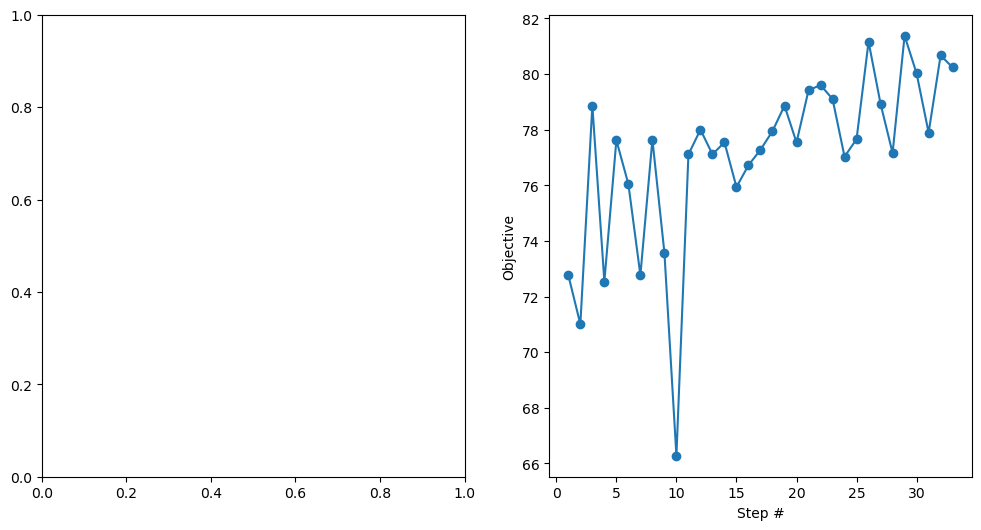

In [24]:
import matplotlib.pyplot as plt

fig,ax = plt.subplots(1,2,squeeze=False,figsize=(12,6))
df = opt.data
ol = ['LT']

ax[0,1].plot(df.loc[:,gvocs.objective_names_active[0]],marker='o')
ax[0,1].set_xlabel('Step #')
ax[0,1].set_ylabel('Objective')

In [25]:
# This will save optimizer state
from datetime import datetime
opt.state_to_json(f'{datetime.now():%Y%m%dT%H%M%S}_sobo_inj_eff_dump.json')

import os
# os.remove('sobo_dump.json')